### Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.window import Window as W
import os
import subprocess
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

POST_JDBC = "/app/postgresql-42.7.8.jar"
FILE_TABELAS_DIR = "/app/parquet_tables"
SCRATCH = "/spark_temp"



### Spark Session Configuration

In [ ]:
spark = SparkSession.builder \
    .appName("DataCrash-ETL") \
    .config("spark.driver.extraClassPath", POST_JDBC)\
    .config("spark.executor.extraClassPath", POST_JDBC)\
    .config("spark.sql.legacy.timeParserPolicy", "CORRECTED")\
    .config("spark.local.dir", SCRATCH)\
    .config("spark.master", "local[*]")\
    .config("spark.driver.memory", "2g") \
    .config("spark.worker.cleanup.enabled", "true")\
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/10/11 04:17:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/11 04:17:58 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).


### Column Definitions

In [3]:
def get_accident_columns():
    """Return list of columns to KEEP for accidents"""
    return [
        'Accident_Index', 'Longitude', 'Latitude', 'Accident_Severity',
        'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 
        'Time', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
        'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 
        'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site',
        'Carriageway_Hazards', 'Urban_or_Rural_Area'
    ]

def get_vehicle_columns():
    """Return list of columns to KEEP for vehicles"""
    return [
        'Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
        'Vehicle_Manoeuvre', 'Vehicle_Location-Restricted_Lane',
        'Was_Vehicle_Left_Hand_Drive?', 'Sex_of_Driver', 'Age_of_Driver',
        'Age_Band_of_Driver', 'Propulsion_Code', 'Age_of_Vehicle'
    ]

def get_casualty_columns():
    """Return list of columns to KEEP for casualties"""
    return [
        'Accident_Index', 'Vehicle_Reference', 'Casualty_Reference',
        'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
        'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Movement',
        'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type'
    ]

print("Column definitions loaded")

Column definitions loaded


### Data Loading Function

In [4]:
def load_and_filter_data(file_path, columns_to_keep):


    df_complete = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .parquet(file_path)

    print(f"{file_path}: {df_complete.count():,} rows, {len(df_complete.columns)} columns")
    df_complete.printSchema()

    
    # Keep only specified columns
    existing_columns = [col for col in columns_to_keep if col in df_complete.columns]
    df_filtered = df_complete.select(existing_columns)
    
    print(f"Filtered: {len(df_filtered.columns)} columns kept")
    df_filtered.printSchema()
    print(f"Sample data from {file_path}:")
    df_filtered.show(5, truncate=False)
    
    return df_filtered

### Load Datasets


In [5]:
df_accidents = load_and_filter_data(
    "/raw/Accidents0515",
    get_accident_columns()
)

# Load vehicles
df_vehicles = load_and_filter_data(
    "/raw/Vehicles0515", 
    get_vehicle_columns()
)

# Load casualties
df_casualties = load_and_filter_data(
    "/raw/Casualties0515",
    get_casualty_columns()
)

print("✅ All datasets loaded successfully")

/raw/Accidents0515: 1,780,653 rows, 32 columns
root
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: integer (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: integer (nullable = true)
 |-- Junction_Control: integer (nullable = true)


+--------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-------------------+---------+-----------+---------------+----------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+
|Accident_Index|Longitude|Latitude |Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Date      |Day_of_Week|Time               |Road_Type|Speed_limit|Junction_Detail|Junction_Control|Pedestrian_Crossing-Physical_Facilities|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Special_Conditions_at_Site|Carriageway_Hazards|Urban_or_Rural_Area|
+--------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-------------------+---------+-----------+---------------+----------------+---------------------------------------+----------------+------------------+------------

/raw/Vehicles0515: 3,262,270 rows, 22 columns
root
 |-- Accident_Index: string (nullable = true)
 |-- Vehicle_Reference: integer (nullable = true)
 |-- Vehicle_Type: integer (nullable = true)
 |-- Towing_and_Articulation: integer (nullable = true)
 |-- Vehicle_Manoeuvre: integer (nullable = true)
 |-- Vehicle_Location-Restricted_Lane: integer (nullable = true)
 |-- Junction_Location: integer (nullable = true)
 |-- Skidding_and_Overturning: integer (nullable = true)
 |-- Hit_Object_in_Carriageway: integer (nullable = true)
 |-- Vehicle_Leaving_Carriageway: integer (nullable = true)
 |-- Hit_Object_off_Carriageway: integer (nullable = true)
 |-- 1st_Point_of_Impact: integer (nullable = true)
 |-- Was_Vehicle_Left_Hand_Drive?: integer (nullable = true)
 |-- Journey_Purpose_of_Driver: integer (nullable = true)
 |-- Sex_of_Driver: integer (nullable = true)
 |-- Age_of_Driver: integer (nullable = true)
 |-- Age_Band_of_Driver: integer (nullable = true)
 |-- Engine_Capacity_(CC): integer (nul

+--------------+-----------------+------------+-----------------+--------------------------------+----------------------------+-------------+-------------+------------------+---------------+--------------+
|Accident_Index|Vehicle_Reference|Vehicle_Type|Vehicle_Manoeuvre|Vehicle_Location-Restricted_Lane|Was_Vehicle_Left_Hand_Drive?|Sex_of_Driver|Age_of_Driver|Age_Band_of_Driver|Propulsion_Code|Age_of_Vehicle|
+--------------+-----------------+------------+-----------------+--------------------------------+----------------------------+-------------+-------------+------------------+---------------+--------------+
|201101BS70342 |1                |9           |2                |0                               |1                           |2            |-1           |-1                |1              |6             |
|201101BS70342 |2                |1           |18               |0                               |1                           |2            |25           |5                 |-1

/raw/Casualties0515: 2,402,909 rows, 15 columns
root
 |-- Accident_Index: string (nullable = true)
 |-- Vehicle_Reference: integer (nullable = true)
 |-- Casualty_Reference: integer (nullable = true)
 |-- Casualty_Class: integer (nullable = true)
 |-- Sex_of_Casualty: integer (nullable = true)
 |-- Age_of_Casualty: integer (nullable = true)
 |-- Age_Band_of_Casualty: integer (nullable = true)
 |-- Casualty_Severity: integer (nullable = true)
 |-- Pedestrian_Location: integer (nullable = true)
 |-- Pedestrian_Movement: integer (nullable = true)
 |-- Car_Passenger: integer (nullable = true)
 |-- Bus_or_Coach_Passenger: integer (nullable = true)
 |-- Pedestrian_Road_Maintenance_Worker: integer (nullable = true)
 |-- Casualty_Type: integer (nullable = true)
 |-- Casualty_Home_Area_Type: integer (nullable = true)

Filtered: 12 columns kept
root
 |-- Accident_Index: string (nullable = true)
 |-- Vehicle_Reference: integer (nullable = true)
 |-- Casualty_Reference: integer (nullable = true)
 

+--------------+-----------------+------------------+--------------+---------------+---------------+--------------------+-----------------+-------------------+-------------+----------------------+-------------+
|Accident_Index|Vehicle_Reference|Casualty_Reference|Casualty_Class|Sex_of_Casualty|Age_of_Casualty|Age_Band_of_Casualty|Casualty_Severity|Pedestrian_Movement|Car_Passenger|Bus_or_Coach_Passenger|Casualty_Type|
+--------------+-----------------+------------------+--------------+---------------+---------------+--------------------+-----------------+-------------------+-------------+----------------------+-------------+
|201304FB13047 |1                |3                 |2             |1              |16             |4                   |3                |0                  |2            |0                     |9            |
|201304FB13047 |1                |4                 |2             |1              |16             |4                   |3                |0                

### Data Quality

In [6]:
print("INICIANDO ANÁLISE DE QUALIDADE PARA TODOS OS DATASETS...")

def safe_quality_analysis(df, df_name):
    print(f"\n📊 {df_name} - QUALITY ANALYSIS")
    print("=" * 40)
    
    # Contagem básica
    total_rows = df.count()
    print(f"Total rows: {total_rows:,}")
    print(f"Total columns: {len(df.columns)}")
    
    # Lista de problemas
    problems = []
    
    # Verificar cada coluna
    for col_name in df.columns:
        print(f"\n{col_name}:")
        
        try:
            # NULL values
            null_count = df.filter(F.col(col_name).isNull()).count()
            if null_count > 0:
                print(f"   ⚠️  NULL: {null_count}")
                problems.append(f"{col_name}: {null_count} NULL")
            else:
                print(f"   ✅ NULL: 0")
                
            # Data type
            dtype = df.schema[col_name].dataType
            print(f"   🏷️  Type: {dtype}")
            
            # Amostra
            samples = df.select(col_name).limit(2).collect()
            sample_values = [str(row[col_name]) for row in samples]
            print(f"   📋 Samples: {sample_values}")
            
        except Exception as e:
            print(f"   ❌ Erro ao analisar: {e}")
            problems.append(f"{col_name}: ERRO - {e}")
    

    print(f"\n📊 RESUMO:")
    print("-" * 20)
    if problems:
        print(f"⚠️  Problemas encontrados: {len(problems)}")
        for problem in problems:
            print(f"   • {problem}")
    else:
        print("🎉 Nenhum problema encontrado!")
    
    return problems

# EXECUTAR PARA TODOS OS DATASETS
print("ANALISANDO ACCIDENTS...")
problems_accidents = safe_quality_analysis(df_accidents, "Accidents")

print("\nANALISANDO VEHICLES...")
problems_vehicles = safe_quality_analysis(df_vehicles, "Vehicles")

print("\nANALISANDO CASUALTIES...") 
problems_casualties = safe_quality_analysis(df_casualties, "Casualties")

print("\n✅ ANÁLISE DE QUALIDADE CONCLUÍDA PARA TODOS OS DATASETS!")

INICIANDO ANÁLISE DE QUALIDADE PARA TODOS OS DATASETS...
ANALISANDO ACCIDENTS...

📊 Accidents - QUALITY ANALYSIS


Total rows: 1,780,653
Total columns: 20

Accident_Index:


   ✅ NULL: 0
   🏷️  Type: StringType()
   📋 Samples: ['201301EK40520', '201301EK40521']

Longitude:


   ⚠️  NULL: 138
   🏷️  Type: DoubleType()
   📋 Samples: ['-0.177694', '-0.158197']

Latitude:


   ⚠️  NULL: 138
   🏷️  Type: DoubleType()
   📋 Samples: ['51.545271', '51.55306']

Accident_Severity:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['3', '3']

Number_of_Vehicles:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['2', '3']

Number_of_Casualties:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Date:


   ✅ NULL: 0
   🏷️  Type: StringType()
   📋 Samples: ['09/08/2013', '10/08/2013']

Day_of_Week:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['6', '7']

Time:


   ⚠️  NULL: 151
   🏷️  Type: TimestampType()
   📋 Samples: ['2025-10-11 11:00:00', '2025-10-11 14:30:00']

Road_Type:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['3', '6']

Speed_limit:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['30', '30']

Junction_Detail:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['3', '6']

Junction_Control:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['4', '2']

Pedestrian_Crossing-Physical_Facilities:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['4', '5']

Light_Conditions:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Weather_Conditions:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Road_Surface_Conditions:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Special_Conditions_at_Site:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['0', '0']

Carriageway_Hazards:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['0', '0']

Urban_or_Rural_Area:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

📊 RESUMO:
--------------------
⚠️  Problemas encontrados: 3
   • Longitude: 138 NULL
   • Latitude: 138 NULL
   • Time: 151 NULL

ANALISANDO VEHICLES...

📊 Vehicles - QUALITY ANALYSIS


Total rows: 3,262,270
Total columns: 11

Accident_Index:
   ✅ NULL: 0
   🏷️  Type: StringType()


   📋 Samples: ['201101BS70342', '201101BS70342']

Vehicle_Reference:
   ✅ NULL: 0
   🏷️  Type: IntegerType()


   📋 Samples: ['1', '2']

Vehicle_Type:
   ✅ NULL: 0
   🏷️  Type: IntegerType()


   📋 Samples: ['9', '1']

Vehicle_Manoeuvre:
   ✅ NULL: 0
   🏷️  Type: IntegerType()


   📋 Samples: ['2', '18']

Vehicle_Location-Restricted_Lane:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['0', '0']

Was_Vehicle_Left_Hand_Drive?:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Sex_of_Driver:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['2', '2']

Age_of_Driver:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['-1', '25']

Age_Band_of_Driver:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['-1', '5']

Propulsion_Code:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '-1']

Age_of_Vehicle:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['6', '-1']

📊 RESUMO:
--------------------
🎉 Nenhum problema encontrado!

ANALISANDO CASUALTIES...

📊 Casualties - QUALITY ANALYSIS


Total rows: 2,402,909
Total columns: 12

Accident_Index:
   ✅ NULL: 0
   🏷️  Type: StringType()


   📋 Samples: ['201304FB13047', '201304FB13047']

Vehicle_Reference:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Casualty_Reference:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['3', '4']

Casualty_Class:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['2', '2']

Sex_of_Casualty:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['1', '1']

Age_of_Casualty:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['16', '16']

Age_Band_of_Casualty:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['4', '4']

Casualty_Severity:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['3', '3']

Pedestrian_Movement:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['0', '0']

Car_Passenger:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['2', '2']

Bus_or_Coach_Passenger:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['0', '0']

Casualty_Type:


   ✅ NULL: 0
   🏷️  Type: IntegerType()
   📋 Samples: ['9', '9']

📊 RESUMO:
--------------------
🎉 Nenhum problema encontrado!

✅ ANÁLISE DE QUALIDADE CONCLUÍDA PARA TODOS OS DATASETS!


### Data Type Conversion

In [7]:
def convert_data_types_simple(df):   
    df_converted = df
    
    # 1. CONVERTER DATE
    if 'Date' in df.columns:
        df_converted = df_converted.withColumn(
            "Date", 
            F.to_date(F.col("Date"), "dd/MM/yyyy")
        )
        print("✅ Date: String → DateType")
    
    # 2. CONVERTER TIME (Timestamp → String no formato HH:mm)
    if 'Time' in df.columns:
        df_converted = df_converted.withColumn(
            "Time",
            F.date_format(F.col("Time"), "HH:mm")
        )
        print("✅ Time: Timestamp → String (HH:mm)")
        
    return df_converted

df_accidents_converted = convert_data_types_simple(df_accidents)

print("\n✅ CONVERSÃO CONCLUÍDA!")

✅ Date: String → DateType
✅ Time: Timestamp → String (HH:mm)

✅ CONVERSÃO CONCLUÍDA!


### Missing Value Treatment

In [8]:
def treat_missing_values(df):    
    original_count = df.count()
    
    # COLUNAS CRÍTICAS (se tiver missing, remove a linha)
    critical_columns = ['Longitude', 'Latitude', 'Time']
    
    # Aplicar filtro para remover missing nas colunas críticas
    condition = None
    for col_name in critical_columns:
        if col_name in df.columns:
            if condition is None:
                condition = F.col(col_name).isNotNull()
            else:
                condition = condition & F.col(col_name).isNotNull()
    
    if condition is not None:
        df_clean = df.filter(condition)
        removed_count = original_count - df_clean.count()
        removed_pct = (removed_count / original_count) * 100
        
        print(f"✅ Removidas {removed_count:,} linhas ({removed_pct:.4f}%) com missing em colunas críticas")
        print(f"📊 Antes: {original_count:,} linhas")
        print(f"📊 Depois: {df_clean.count():,} linhas")
    else:
        df_clean = df
        print("Nenhum missing encontrado nas colunas críticas")
    
    return df_clean

# EXECUTAR TRATAMENTO
df_accidents_clean = treat_missing_values(df_accidents_converted)

print("\n✅ TRATAMENTO DE MISSING CONCLUÍDO!")

✅ Removidas 289 linhas (0.0162%) com missing em colunas críticas
📊 Antes: 1,780,653 linhas


📊 Depois: 1,780,364 linhas

✅ TRATAMENTO DE MISSING CONCLUÍDO!


### Referential Integrity Cleanup

In [9]:
def ensure_referential_integrity(accidents_df, vehicles_df, casualties_df):
    """Remove veículos e vítimas de acidentes excluídos"""
    print("📋 Sincronizando datasets...")
    
    # Lista de Accident_Index válidos (após limpeza)
    valid_accidents = accidents_df.select("Accident_Index").distinct()
    
    # Contagens antes
    vehicles_before = vehicles_df.count()
    casualties_before = casualties_df.count()
    
    # Filtrar veículos e vítimas para manter só os que têm acidentes válidos
    vehicles_clean = vehicles_df.join(valid_accidents, "Accident_Index", "inner")
    casualties_clean = casualties_df.join(valid_accidents, "Accident_Index", "inner")
    
    # Contagens depois
    vehicles_after = vehicles_clean.count()
    casualties_after = casualties_clean.count()
    
    # Estatísticas
    vehicles_removed = vehicles_before - vehicles_after
    casualties_removed = casualties_before - casualties_after
    
    print(f"✅ Veículos: {vehicles_before:,} → {vehicles_after:,} (removidos {vehicles_removed:,})")
    print(f"✅ Vítimas: {casualties_before:,} → {casualties_after:,} (removidos {casualties_removed:,})")
    
    return vehicles_clean, casualties_clean

# EXECUTAR LIMPEZA DE INTEGRIDADE
print("REMOVENDO DADOS ÓRFÃOS...")
df_vehicles_clean, df_casualties_clean = ensure_referential_integrity(
    df_accidents_clean, df_vehicles, df_casualties
)

print("\n✅ INTEGRIDADE REFERENCIAL GARANTIDA!")

REMOVENDO DADOS ÓRFÃOS...
📋 Sincronizando datasets...


✅ Veículos: 3,262,270 → 3,261,764 (removidos 506)
✅ Vítimas: 2,402,909 → 2,402,551 (removidos 358)

✅ INTEGRIDADE REFERENCIAL GARANTIDA!


### Domain Validation 

In [10]:
def validate_all_domains(df, df_name):
    """Valida TODAS as colunas com códigos"""
    print(f"\n {df_name} - COMPREHENSIVE DOMAIN VALIDATION")
    print("=" * 50)
    
    issues = []
    
    validation_rules = {
        # ACCIDENTS
        'Accident_Severity': [1, 2, 3],
        'Day_of_Week': [1, 2, 3, 4, 5, 6, 7],
        'Road_Type': [1, 2, 3, 6, 7, 9, 12],
        'Speed_limit': [0, 10, 15, 20, 30, 40, 50, 60, 70],
        'Junction_Detail': [0, 1, 2, 3, 5, 6, 7, 8, 9, -1],
        'Junction_Control': [0, 1, 2, 3, 4, -1],
        'Pedestrian_Crossing-Physical_Facilities': [0, 1, 4, 5, 7, 8, -1],
        'Light_Conditions': [1, 4, 5, 6, 7, -1],
        'Weather_Conditions': [1, 2, 3, 4, 5, 6, 7, 8, 9, -1],
        'Road_Surface_Conditions': [1, 2, 3, 4, 5, 6, 7, -1],
        'Special_Conditions_at_Site': [0, 1, 2, 3, 4, 5, 6, 7, -1],
        'Carriageway_Hazards': [0, 1, 2, 3, 4, 5, 6, 7, -1],
        'Urban_or_Rural_Area': [1, 2, 3],
        
        # VEHICLES
        'Vehicle_Type': list(range(1, 99)) + [-1],  # 1-98 + -1
        'Vehicle_Manoeuvre': list(range(1, 19)) + [-1],
        'Vehicle_Location-Restricted_Lane': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1],
        'Sex_of_Driver': [1, 2, 3, -1],
        'Age_Band_of_Driver': list(range(1, 12)) + [-1],
        'Propulsion_Code': list(range(1, 13)) + [-1],
        
        # CASUALTIES  
        'Casualty_Class': [1, 2, 3],
        'Sex_of_Casualty': [1, 2, 3, -1],
        'Age_Band_of_Casualty': list(range(1, 12)) + [-1],
        'Casualty_Severity': [1, 2, 3],
        'Pedestrian_Movement': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1],
        'Car_Passenger': [0, 1, 2, 9, -1],
        'Bus_or_Coach_Passenger': [0, 1, 2, 3, 4, 9, -1],
        'Casualty_Type': [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98, -1]
    }
    
    for col_name, valid_values in validation_rules.items():
        if col_name in df.columns:
            # Contar valores fora do domínio
            invalid_count = df.filter(~F.col(col_name).isin(valid_values)).count()
            
            if invalid_count > 0:
                # Pegar exemplos dos valores inválidos
                invalid_samples = df.filter(~F.col(col_name).isin(valid_values)) \
                                  .select(col_name).distinct().limit(3).collect()
                
                samples = [row[col_name] for row in invalid_samples]
                issues.append(f"{col_name}: {invalid_count} inválidos - Ex: {samples}")
                print(f"   {col_name}: {invalid_count} valores inválidos")
                print(f"      Exemplos: {samples}")
            else:
                print(f"   ✅ {col_name}: Todos os {df.select(col_name).distinct().count()} valores estão no domínio")
    
    print(f"\n📊 RESUMO DE VALIDAÇÃO:")
    print("-" * 30)
    if issues:
        print(f"⚠  Problemas encontrados: {len(issues)}")
        for issue in issues:
            print(f"   • {issue}")
    else:
        print("Todos os domínios estão válidos!")
    
    return issues

# EXECUTAR VALIDAÇÃO COMPLETA
print("VALIDANDO ACCIDENTS...")
issues_accidents = validate_all_domains(df_accidents_clean, "Accidents")

print("\nVALIDANDO VEHICLES...")
issues_vehicles = validate_all_domains(df_vehicles_clean, "Vehicles")

print("\nVALIDANDO CASUALTIES...")
issues_casualties = validate_all_domains(df_casualties_clean, "Casualties")

print("\n VALIDAÇÃO COMPLETA DE DOMÍNIOS CONCLUÍDA!")

VALIDANDO ACCIDENTS...

 Accidents - COMPREHENSIVE DOMAIN VALIDATION


   ✅ Accident_Severity: Todos os 3 valores estão no domínio


   ✅ Day_of_Week: Todos os 7 valores estão no domínio


   ✅ Road_Type: Todos os 6 valores estão no domínio


   ✅ Speed_limit: Todos os 9 valores estão no domínio


   ✅ Junction_Detail: Todos os 10 valores estão no domínio


   ✅ Junction_Control: Todos os 6 valores estão no domínio


   ✅ Pedestrian_Crossing-Physical_Facilities: Todos os 7 valores estão no domínio


   ✅ Light_Conditions: Todos os 5 valores estão no domínio


   ✅ Weather_Conditions: Todos os 10 valores estão no domínio


   ✅ Road_Surface_Conditions: Todos os 6 valores estão no domínio


   ✅ Special_Conditions_at_Site: Todos os 9 valores estão no domínio


   ✅ Carriageway_Hazards: Todos os 7 valores estão no domínio


   ✅ Urban_or_Rural_Area: Todos os 3 valores estão no domínio

📊 RESUMO DE VALIDAÇÃO:
------------------------------
Todos os domínios estão válidos!

VALIDANDO VEHICLES...

 Vehicles - COMPREHENSIVE DOMAIN VALIDATION


   ✅ Vehicle_Type: Todos os 21 valores estão no domínio


   ✅ Vehicle_Manoeuvre: Todos os 19 valores estão no domínio


   ✅ Vehicle_Location-Restricted_Lane: Todos os 11 valores estão no domínio


   ✅ Sex_of_Driver: Todos os 4 valores estão no domínio


   ✅ Age_Band_of_Driver: Todos os 12 valores estão no domínio


   ✅ Propulsion_Code: Todos os 13 valores estão no domínio

📊 RESUMO DE VALIDAÇÃO:
------------------------------
Todos os domínios estão válidos!

VALIDANDO CASUALTIES...

 Casualties - COMPREHENSIVE DOMAIN VALIDATION


   ✅ Casualty_Class: Todos os 3 valores estão no domínio


   ✅ Sex_of_Casualty: Todos os 3 valores estão no domínio


   ✅ Age_Band_of_Casualty: Todos os 12 valores estão no domínio


   ✅ Casualty_Severity: Todos os 3 valores estão no domínio


   ✅ Pedestrian_Movement: Todos os 11 valores estão no domínio


   ✅ Car_Passenger: Todos os 4 valores estão no domínio


   ✅ Bus_or_Coach_Passenger: Todos os 6 valores estão no domínio


   ✅ Casualty_Type: Todos os 21 valores estão no domínio

📊 RESUMO DE VALIDAÇÃO:
------------------------------
Todos os domínios estão válidos!

 VALIDAÇÃO COMPLETA DE DOMÍNIOS CONCLUÍDA!


In [11]:
# Renomear colunas para snake_case
def rename_columns(df, rename_dict):
    df_renamed = df
    for col_name in df.columns:
        df_renamed = df_renamed.withColumnRenamed(col_name, col_name.lower())

    for old_name, new_name in rename_dict.items():
        if old_name in df_renamed.columns:
            df_renamed = df_renamed.withColumnRenamed(old_name, new_name)

    return df_renamed

renomear = {"date": "accident_timestamp", "time": "accident_time", "pedestrian_crossing-physical_facilities": "pedestrian_crossing_physical_facilities", "was_vehicle_left_hand_drive?": "was_vehicle_left_hand_drive", "vehicle_location-restricted_lane": "vehicle_location_restricted_lane"}
df_accidents_clean = rename_columns(df_accidents_clean, renomear)
df_vehicles_clean = rename_columns(df_vehicles_clean, renomear)
df_casualties_clean = rename_columns(df_casualties_clean, renomear)



In [12]:
# Juntar os três dataframes usando Accident_Index como chave
df_joined = df_accidents_clean \
    .join(df_vehicles_clean, on="Accident_Index", how="inner") \
    .join(df_casualties_clean, on=["Accident_Index", "Vehicle_Reference"], how="inner")

print(f"Dataframe final: {df_joined.count():,} linhas, {len(df_joined.columns)} colunas")
df_joined.printSchema()

Dataframe final: 2,402,551 linhas, 40 colunas
root
 |-- accident_index: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- accident_timestamp: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- accident_time: string (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- speed_limit: integer (nullable = true)
 |-- junction_detail: integer (nullable = true)
 |-- junction_control: integer (nullable = true)
 |-- pedestrian_crossing_physical_facilities: integer (nullable = true)
 |-- light_conditions: integer (nullable = true)
 |-- weather_conditions: integer (nullable = true)
 |-- road_surface_conditions: integer (nullable = true)
 |-- special_conditions_at_site: integer (nullable = true)
 |-- carria

In [13]:
df_accidents_clean.write.mode("overwrite").parquet(os.path.join(FILE_TABELAS_DIR, "accident"))
df_vehicles_clean.write.mode("overwrite").parquet(os.path.join(FILE_TABELAS_DIR, "vehicle"))
df_casualties_clean.write.mode("overwrite").parquet(os.path.join(FILE_TABELAS_DIR, "casualty"))
df_joined.write.mode("overwrite").parquet(os.path.join(FILE_TABELAS_DIR, "joined"))

print("✅ Todos os dataframes foram salvos em Parquet!")

✅ Todos os dataframes foram salvos em Parquet!


In [14]:
# Configurações do banco de dados Postgres
postgres_url = "jdbc:postgresql://db:5432/gis"
postgres_properties = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver"
}

def lowercase_columns(df):
    df_renamed = df
    for col_name in df.columns:
        df_renamed = df_renamed.withColumnRenamed(col_name, col_name.lower())
    return df_renamed

# Salvar os dataframes no Postgres
df_joined.write.mode("overwrite").jdbc(
    url=postgres_url,
    table="joined",
    properties=postgres_properties
)

df_casualties_clean.write.mode("overwrite").jdbc(
    url=postgres_url,
    table="casualty",
    properties=postgres_properties
)

df_vehicles_clean.write.mode("overwrite").jdbc(
    url=postgres_url,
    table="vehicle",
    properties=postgres_properties
)


df_accidents_clean.write.mode("overwrite").jdbc(
    url=postgres_url,
    table="accident",
    properties=postgres_properties
)


print("✅ Todos os dataframes foram salvos no banco de dados Postgres!")

✅ Todos os dataframes foram salvos no banco de dados Postgres!


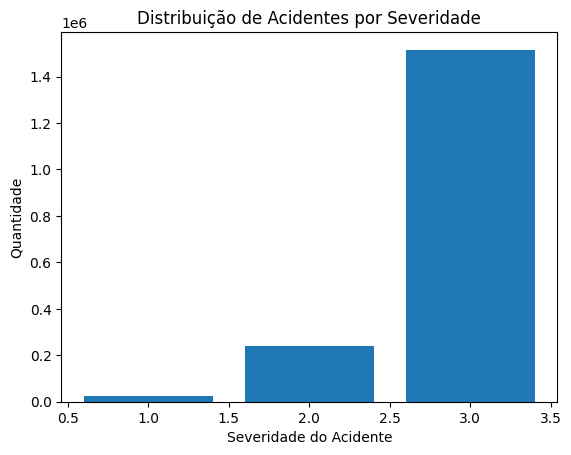

In [15]:
# Contar acidentes por severidade
accident_severity = df_accidents_clean.groupBy("Accident_Severity").count().orderBy("Accident_Severity").toPandas()

plt.bar(accident_severity["Accident_Severity"], accident_severity["count"])
plt.xlabel("Severidade do Acidente")
plt.ylabel("Quantidade")
plt.title("Distribuição de Acidentes por Severidade")
plt.show()